<a href="https://colab.research.google.com/github/yevonnaelandrew/galaxy-classification-ensemble/blob/main/All_Color_Space_ResNet50_Non_trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri May 20 01:30:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   31C    P0    27W / 165W |      9MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
def train_model(convert_color, original=False, preprocess=False):
  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.resnet.ResNet152(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if original == True:
    print("Using the original RGB and preprocessing")
    x = tf.keras.applications.resnet.preprocess_input(x)
  elif original == False:
    x = tf.keras.layers.Rescaling(scale=1./255)(x)
    x = convert_color(x)
    print("Using the converted colors")

  if preprocess == True:
    x = tf.keras.applications.resnet.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
234708992/234698864 [==============================] - 189s 1us/step
Using the original RGB and preprocessing
Epoch 1/100
360/360 [==============================] - 42s 84ms/step - loss: 0.6902 - accuracy: 0.7331 - val_loss: 0.4681 - val_accuracy: 0.7998
Epoch 2/100
360/360 [==============================] - 28s 77ms/step - loss: 0.5067 - accuracy: 0.7851 - val_loss: 0.4417 - val_accuracy: 0.8135
Epoch 3/100
360/360 [==============================] - 27s 75ms/step - loss: 0.4737 - accuracy: 0.8016 - val_loss: 0.4189 - val_accuracy: 0.8215
Epoch 4/100
360/360 [==============================] - 27s 75ms/step - loss: 0.4539 - accuracy: 0.8067 - val_loss: 0.4009 - val_accuracy: 0.8288
Epoch 5/100
360/360 [==============================] - 27s 75ms/step - loss: 0.4440 - accuracy: 0.8132 - val_loss: 0.4059 - val_accuracy: 0.8229
Epoch 6/100
360/

Epoch 54/100
360/360 [==============================] - 27s 74ms/step - loss: 0.3023 - accuracy: 0.8776 - val_loss: 0.3207 - val_accuracy: 0.8734
Epoch 55/100
360/360 [==============================] - 26s 72ms/step - loss: 0.3044 - accuracy: 0.8790 - val_loss: 0.3230 - val_accuracy: 0.8713
Epoch 56/100
360/360 [==============================] - 26s 73ms/step - loss: 0.3053 - accuracy: 0.8747 - val_loss: 0.3160 - val_accuracy: 0.8774
Epoch 57/100
360/360 [==============================] - 27s 74ms/step - loss: 0.3057 - accuracy: 0.8777 - val_loss: 0.3179 - val_accuracy: 0.8791
Epoch 58/100
360/360 [==============================] - 26s 72ms/step - loss: 0.3044 - accuracy: 0.8780 - val_loss: 0.3150 - val_accuracy: 0.8753
Epoch 59/100
360/360 [==============================] - 27s 76ms/step - loss: 0.2964 - accuracy: 0.8821 - val_loss: 0.3126 - val_accuracy: 0.8786
Epoch 60/100
360/360 [==============================] - 26s 73ms/step - loss: 0.3059 - accuracy: 0.8779 - val_loss: 0.3145 -

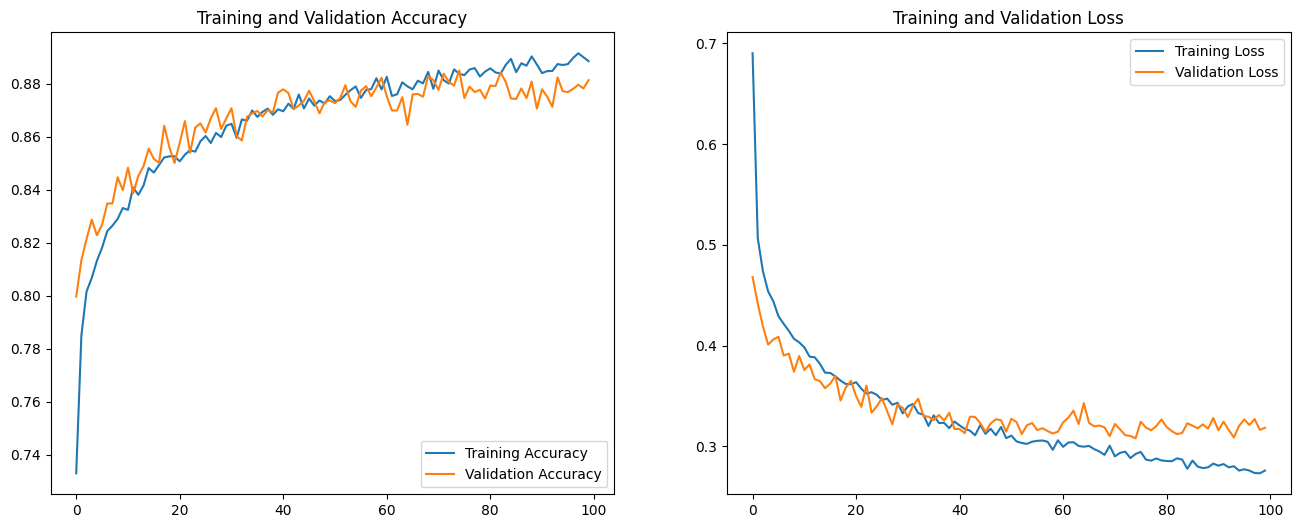

In [4]:
res_rgb = train_model(None, original=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 40s 85ms/step - loss: 0.7008 - accuracy: 0.7171 - val_loss: 0.5340 - val_accuracy: 0.7692
Epoch 2/100
360/360 [==============================] - 29s 81ms/step - loss: 0.5788 - accuracy: 0.7525 - val_loss: 0.5068 - val_accuracy: 0.7853
Epoch 3/100
360/360 [==============================] - 28s 78ms/step - loss: 0.5460 - accuracy: 0.7652 - val_loss: 0.5096 - val_accuracy: 0.7838
Epoch 4/100
360/360 [==============================] - 27s 76ms/step - loss: 0.5308 - accuracy: 0.7755 - val_loss: 0.4860 - val_accuracy: 0.7958
Epoch 5/100
360/360 [==============================] - 28s 78ms/step - loss: 0.5175 - accuracy: 0.7825 - val_loss: 0.4959 - val_accuracy: 0.7897
Epoch 6/100
360/360 [==============================] - 27s 76ms/step - loss: 0.

Epoch 56/100
360/360 [==============================] - 28s 77ms/step - loss: 0.3718 - accuracy: 0.8481 - val_loss: 0.3936 - val_accuracy: 0.8444
Epoch 57/100
360/360 [==============================] - 27s 76ms/step - loss: 0.3637 - accuracy: 0.8522 - val_loss: 0.3939 - val_accuracy: 0.8427
Epoch 58/100
360/360 [==============================] - 27s 75ms/step - loss: 0.3679 - accuracy: 0.8489 - val_loss: 0.4002 - val_accuracy: 0.8440
Epoch 59/100
360/360 [==============================] - 27s 75ms/step - loss: 0.3715 - accuracy: 0.8473 - val_loss: 0.3936 - val_accuracy: 0.8460
Epoch 60/100
360/360 [==============================] - 28s 77ms/step - loss: 0.3719 - accuracy: 0.8508 - val_loss: 0.3967 - val_accuracy: 0.8423
Epoch 61/100
360/360 [==============================] - 27s 76ms/step - loss: 0.3610 - accuracy: 0.8541 - val_loss: 0.4089 - val_accuracy: 0.8381
Epoch 62/100
360/360 [==============================] - 27s 75ms/step - loss: 0.3755 - accuracy: 0.8464 - val_loss: 0.3991 -

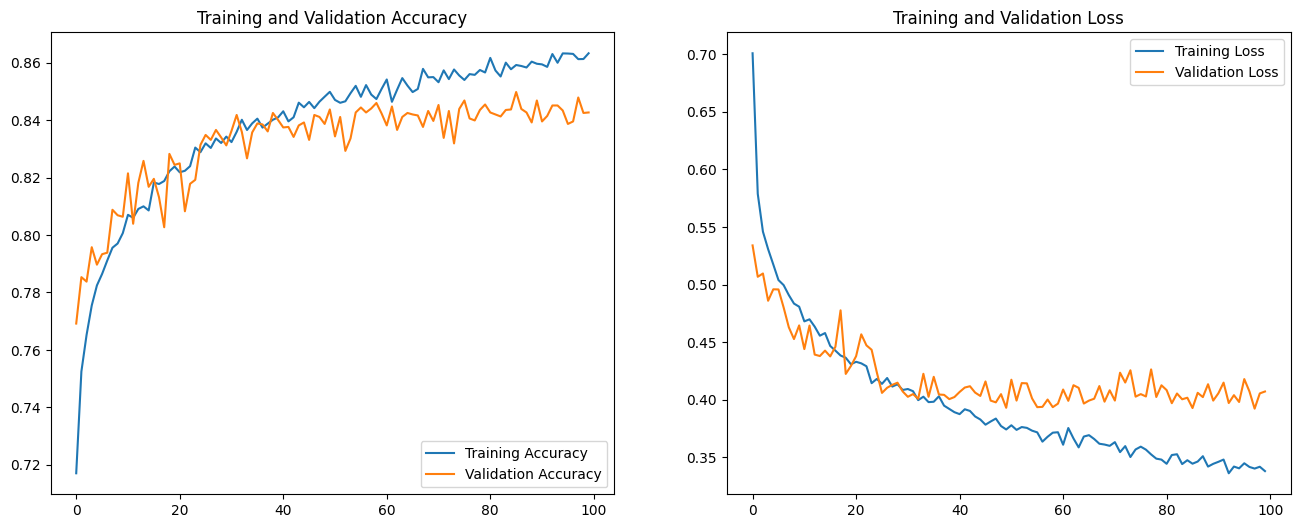

In [5]:
res_lab_pre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 45s 98ms/step - loss: 0.8873 - accuracy: 0.6645 - val_loss: 0.6084 - val_accuracy: 0.7506
Epoch 2/100
360/360 [==============================] - 29s 80ms/step - loss: 0.6471 - accuracy: 0.7297 - val_loss: 0.5761 - val_accuracy: 0.7593
Epoch 3/100
360/360 [==============================] - 28s 77ms/step - loss: 0.6101 - accuracy: 0.7438 - val_loss: 0.5571 - val_accuracy: 0.7685
Epoch 4/100
360/360 [==============================] - 28s 78ms/step - loss: 0.5980 - accuracy: 0.7523 - val_loss: 0.5478 - val_accuracy: 0.7721
Epoch 5/100
360/360 [==============================] - 28s 77ms/step - loss: 0.5821 - accuracy: 0.7554 - val_loss: 0.5431 - val_accuracy: 0.7744
Epoch 6/100
360/360 [==============================] - 32s 90ms/step - loss: 0.5636 - accuracy: 0.7

Epoch 56/100
360/360 [==============================] - 27s 76ms/step - loss: 0.4334 - accuracy: 0.8258 - val_loss: 0.4451 - val_accuracy: 0.8329
Epoch 57/100
360/360 [==============================] - 27s 76ms/step - loss: 0.4357 - accuracy: 0.8251 - val_loss: 0.4388 - val_accuracy: 0.8286
Epoch 58/100
360/360 [==============================] - 27s 75ms/step - loss: 0.4294 - accuracy: 0.8233 - val_loss: 0.4519 - val_accuracy: 0.8208
Epoch 59/100
360/360 [==============================] - 28s 77ms/step - loss: 0.4332 - accuracy: 0.8243 - val_loss: 0.4581 - val_accuracy: 0.8244
Epoch 60/100
360/360 [==============================] - 28s 76ms/step - loss: 0.4309 - accuracy: 0.8283 - val_loss: 0.4470 - val_accuracy: 0.8253
Epoch 61/100
360/360 [==============================] - 27s 75ms/step - loss: 0.4321 - accuracy: 0.8272 - val_loss: 0.4405 - val_accuracy: 0.8308
Epoch 62/100
360/360 [==============================] - 27s 76ms/step - loss: 0.4336 - accuracy: 0.8264 - val_loss: 0.4400 -

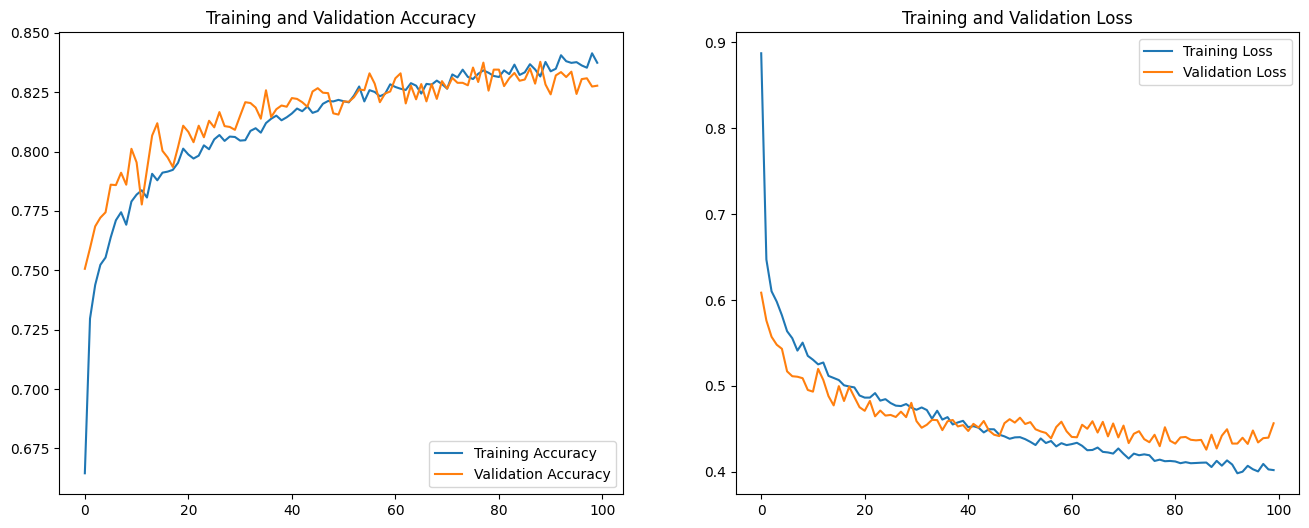

In [6]:
res_lab_nonpre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 39s 85ms/step - loss: 1.4168 - accuracy: 0.3361 - val_loss: 1.3400 - val_accuracy: 0.4109
Epoch 2/100
360/360 [==============================] - 28s 77ms/step - loss: 1.3466 - accuracy: 0.3901 - val_loss: 1.2810 - val_accuracy: 0.4460
Epoch 3/100
360/360 [==============================] - 27s 75ms/step - loss: 1.3204 - accuracy: 0.4048 - val_loss: 1.2688 - val_accuracy: 0.4328
Epoch 4/100
360/360 [==============================] - 27s 76ms/step - loss: 1.2968 - accuracy: 0.4167 - val_loss: 1.2439 - val_accuracy: 0.4387
Epoch 5/100
360/360 [==============================] - 28s 77ms/step - loss: 1.2875 - accuracy: 0.4268 - val_loss: 1.2222 - val_accuracy: 0.4335
Epoch 6/100
360/360 [==============================] - 27s 76ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 27s 76ms/step - loss: 1.1490 - accuracy: 0.5086 - val_loss: 1.0536 - val_accuracy: 0.5547
Epoch 57/100
360/360 [==============================] - 28s 77ms/step - loss: 1.1438 - accuracy: 0.5136 - val_loss: 1.0511 - val_accuracy: 0.5457
Epoch 58/100
360/360 [==============================] - 27s 76ms/step - loss: 1.1384 - accuracy: 0.5189 - val_loss: 1.0284 - val_accuracy: 0.5646
Epoch 59/100
360/360 [==============================] - 27s 76ms/step - loss: 1.1390 - accuracy: 0.5122 - val_loss: 1.0354 - val_accuracy: 0.5853
Epoch 60/100
360/360 [==============================] - 27s 76ms/step - loss: 1.1307 - accuracy: 0.5181 - val_loss: 1.0262 - val_accuracy: 0.5768
Epoch 61/100
360/360 [==============================] - 27s 75ms/step - loss: 1.1260 - accuracy: 0.5191 - val_loss: 1.0158 - val_accuracy: 0.5695
Epoch 62/100
360/360 [==============================] - 27s 76ms/step - loss: 1.1390 - accuracy: 0.5128 - val_loss: 1.0347 -

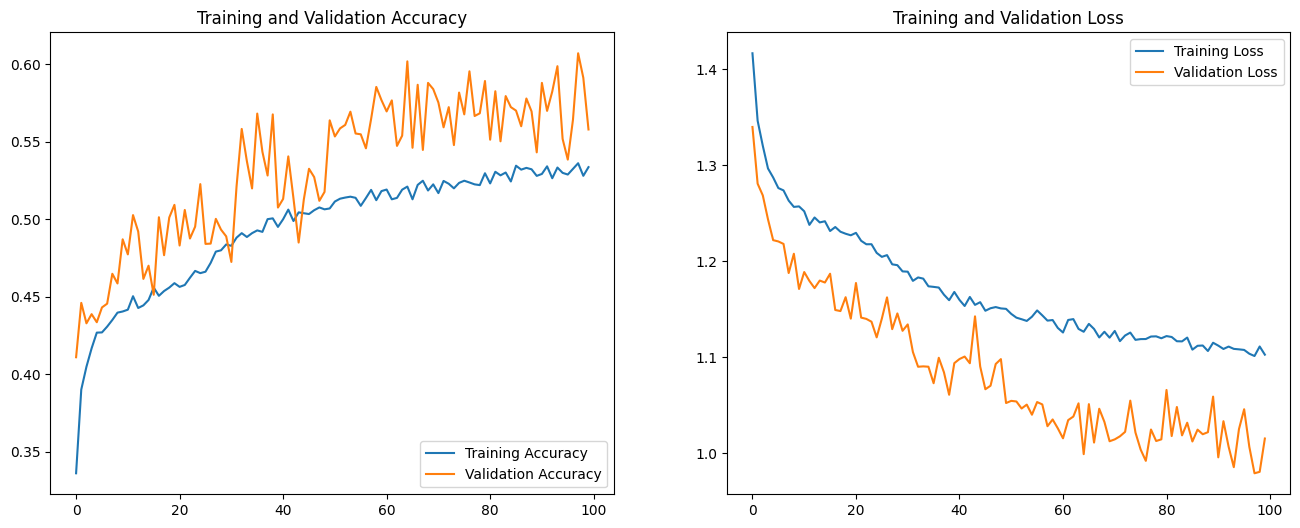

In [7]:
res_xyz_pre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 40s 84ms/step - loss: 1.4426 - accuracy: 0.2920 - val_loss: 1.4069 - val_accuracy: 0.4066
Epoch 2/100
360/360 [==============================] - 28s 79ms/step - loss: 1.4145 - accuracy: 0.3139 - val_loss: 1.3999 - val_accuracy: 0.3567
Epoch 3/100
360/360 [==============================] - 27s 76ms/step - loss: 1.3960 - accuracy: 0.3401 - val_loss: 1.3749 - val_accuracy: 0.3367
Epoch 4/100
360/360 [==============================] - 28s 77ms/step - loss: 1.3843 - accuracy: 0.3542 - val_loss: 1.3356 - val_accuracy: 0.4147
Epoch 5/100
360/360 [==============================] - 33s 92ms/step - loss: 1.3683 - accuracy: 0.3695 - val_loss: 1.3425 - val_accuracy: 0.3675
Epoch 6/100
360/360 [==============================] - 27s 76ms/step - loss: 1.3666 - accuracy: 0.3

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



360/360 [==============================] - 27s 75ms/step - loss: 1.2769 - accuracy: 0.4339 - val_loss: 1.1991 - val_accuracy: 0.4866
Epoch 63/100
360/360 [==============================] - 27s 76ms/step - loss: 1.2728 - accuracy: 0.4339 - val_loss: 1.2119 - val_accuracy: 0.4661
Epoch 64/100
360/360 [==============================] - 27s 76ms/step - loss: 1.2752 - accuracy: 0.4355 - val_loss: 1.2152 - val_accuracy: 0.4673
Epoch 65/100
360/360 [==============================] - 27s 75ms/step - loss: 1.2713 - accuracy: 0.4384 - val_loss: 1.2197 - val_accuracy: 0.4644
Epoch 66/100
360/360 [==============================] - 27s 75ms/step - loss: 1.2759 - accuracy: 0.4322 - val_loss: 1.2169 - val_accuracy: 0.4701
Epoch 67/100
360/360 [==============================] - 27s 75ms/step - loss: 1.2757 - accuracy: 0.4369 - val_loss: 1.2374 - val_accuracy: 0.4564
Epoch 68/100
360/360 [==============================] - 27s 76ms/step - loss: 1.2733 - accuracy: 0.4353 - val_loss: 1.2283 - val_accuracy

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



360/360 [==============================] - 27s 76ms/step - loss: 1.2623 - accuracy: 0.4406 - val_loss: 1.2130 - val_accuracy: 0.4689
Epoch 94/100
360/360 [==============================] - 27s 76ms/step - loss: 1.2639 - accuracy: 0.4373 - val_loss: 1.1942 - val_accuracy: 0.4913
Epoch 95/100
360/360 [==============================] - 27s 76ms/step - loss: 1.2661 - accuracy: 0.4369 - val_loss: 1.2071 - val_accuracy: 0.4698
Epoch 96/100
360/360 [==============================] - 27s 75ms/step - loss: 1.2709 - accuracy: 0.4355 - val_loss: 1.1872 - val_accuracy: 0.4899
Epoch 97/100
360/360 [==============================] - 27s 76ms/step - loss: 1.2615 - accuracy: 0.4404 - val_loss: 1.2145 - val_accuracy: 0.4852
Epoch 98/100
360/360 [==============================] - 27s 76ms/step - loss: 1.2605 - accuracy: 0.4442 - val_loss: 1.2019 - val_accuracy: 0.4774
Epoch 99/100
360/360 [==============================] - 27s 76ms/step - loss: 1.2668 - accuracy: 0.4345 - val_loss: 1.2101 - val_accuracy

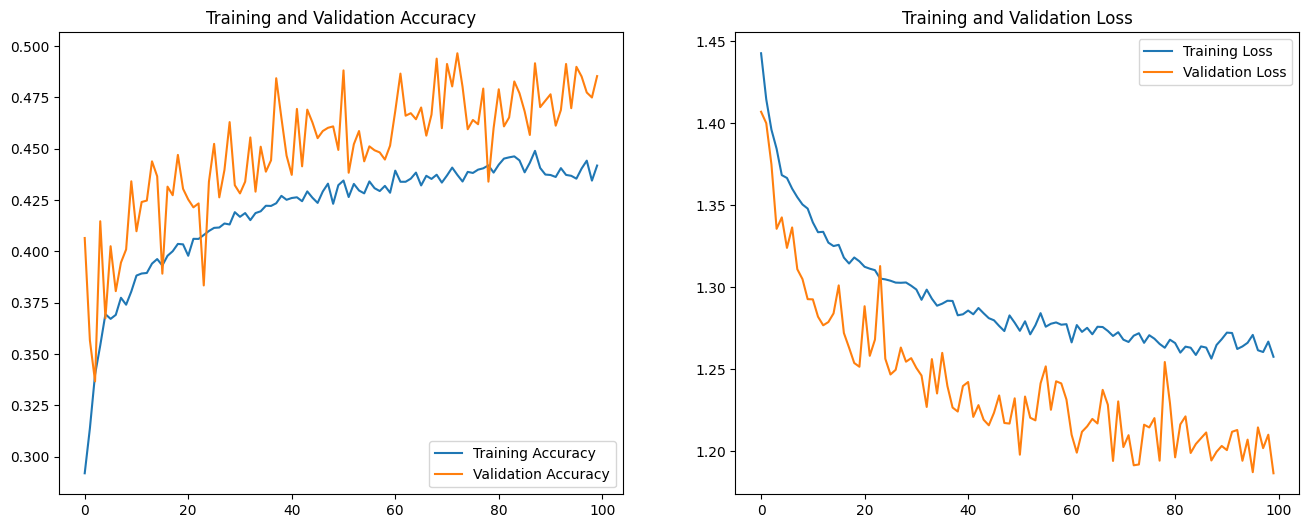

In [8]:
res_xyz_nonpre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=False)

In [9]:
res_hsv_pre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 38s 79ms/step - loss: 1.2806 - accuracy: 0.4230 - val_loss: 1.1851 - val_accuracy: 0.4960
Epoch 2/100
360/360 [==============================] - 27s 74ms/step - loss: 1.2020 - accuracy: 0.4620 - val_loss: 1.1091 - val_accuracy: 0.5071
Epoch 3/100
360/360 [==============================] - 27s 74ms/step - loss: 1.1684 - accuracy: 0.4826 - val_loss: 1.0785 - val_accuracy: 0.5123
Epoch 4/100
360/360 [==============================] - 27s 74ms/step - loss: 1.1609 - accuracy: 0.4855 - val_loss: 1.0733 - val_accuracy: 0.5045
Epoch 5/100
360/360 [==============================] - 27s 74ms/step - loss: 1.1451 - accuracy: 0.4907 - val_loss: 1.0671 - val_accuracy: 0.5318
Epoch 6/100
360/360 [==============================] - 27s 75ms/step - loss: 1.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



360/360 [==============================] - 26s 72ms/step - loss: 1.0888 - accuracy: 0.5244 - val_loss: 1.0588 - val_accuracy: 0.5254
Epoch 33/100
360/360 [==============================] - 26s 73ms/step - loss: 1.0836 - accuracy: 0.5270 - val_loss: 1.0091 - val_accuracy: 0.5455
Epoch 34/100
360/360 [==============================] - 26s 73ms/step - loss: 1.0852 - accuracy: 0.5260 - val_loss: 1.0152 - val_accuracy: 0.5443
Epoch 35/100
360/360 [==============================] - 26s 71ms/step - loss: 1.0791 - accuracy: 0.5303 - val_loss: 1.0019 - val_accuracy: 0.5651
Epoch 36/100
360/360 [==============================] - 26s 73ms/step - loss: 1.0862 - accuracy: 0.5256 - val_loss: 1.0024 - val_accuracy: 0.5542
Epoch 37/100
360/360 [==============================] - 26s 72ms/step - loss: 1.0768 - accuracy: 0.5259 - val_loss: 0.9989 - val_accuracy: 0.5617
Epoch 38/100
360/360 [==============================] - 26s 73ms/step - loss: 1.0784 - accuracy: 0.5295 - val_loss: 1.0082 - val_accuracy

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



360/360 [==============================] - 26s 72ms/step - loss: 1.0714 - accuracy: 0.5341 - val_loss: 0.9873 - val_accuracy: 0.5698
Epoch 62/100
360/360 [==============================] - 26s 72ms/step - loss: 1.0666 - accuracy: 0.5316 - val_loss: 0.9920 - val_accuracy: 0.5651
Epoch 63/100
360/360 [==============================] - 26s 73ms/step - loss: 1.0733 - accuracy: 0.5297 - val_loss: 0.9838 - val_accuracy: 0.5644
Epoch 64/100
360/360 [==============================] - 27s 74ms/step - loss: 1.0697 - accuracy: 0.5339 - val_loss: 0.9822 - val_accuracy: 0.5615
Epoch 65/100
360/360 [==============================] - 27s 76ms/step - loss: 1.0599 - accuracy: 0.5393 - val_loss: 0.9973 - val_accuracy: 0.5634
Epoch 66/100
360/360 [==============================] - 26s 73ms/step - loss: 1.0657 - accuracy: 0.5325 - val_loss: 0.9944 - val_accuracy: 0.5542
Epoch 67/100
360/360 [==============================] - 26s 72ms/step - loss: 1.0622 - accuracy: 0.5377 - val_loss: 0.9784 - val_accuracy

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



360/360 [==============================] - 26s 72ms/step - loss: 1.0581 - accuracy: 0.5359 - val_loss: 0.9743 - val_accuracy: 0.5696
Epoch 93/100
360/360 [==============================] - 26s 73ms/step - loss: 1.0520 - accuracy: 0.5444 - val_loss: 0.9702 - val_accuracy: 0.5742
Epoch 94/100
360/360 [==============================] - 26s 72ms/step - loss: 1.0542 - accuracy: 0.5387 - val_loss: 0.9694 - val_accuracy: 0.5743
Epoch 95/100
360/360 [==============================] - 26s 73ms/step - loss: 1.0533 - accuracy: 0.5380 - val_loss: 0.9734 - val_accuracy: 0.5743
Epoch 96/100
360/360 [==============================] - 26s 73ms/step - loss: 1.0531 - accuracy: 0.5433 - val_loss: 0.9793 - val_accuracy: 0.5683
Epoch 97/100
360/360 [==============================] - 27s 75ms/step - loss: 1.0618 - accuracy: 0.5352 - val_loss: 0.9699 - val_accuracy: 0.5702
Epoch 98/100
360/360 [==============================] - 27s 74ms/step - loss: 1.0521 - accuracy: 0.5457 - val_loss: 0.9752 - val_accuracy

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
res_hsv_nonpre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 39s 82ms/step - loss: 1.3518 - accuracy: 0.3773 - val_loss: 1.2258 - val_accuracy: 0.4446
Epoch 2/100
360/360 [==============================] - 27s 75ms/step - loss: 1.2453 - accuracy: 0.4388 - val_loss: 1.1627 - val_accuracy: 0.4774
Epoch 3/100
360/360 [==============================] - 27s 76ms/step - loss: 1.2130 - accuracy: 0.4528 - val_loss: 1.1111 - val_accuracy: 0.5115
Epoch 4/100
360/360 [==============================] - 27s 75ms/step - loss: 1.1996 - accuracy: 0.4593 - val_loss: 1.0938 - val_accuracy: 0.5221
Epoch 5/100
360/360 [==============================] - 27s 74ms/step - loss: 1.1932 - accuracy: 0.4668 - val_loss: 1.1418 - val_accuracy: 0.4871
Epoch 6/100
360/360 [==============================] - 27s 76ms/step - loss: 1.1848 - accuracy: 0.4

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



360/360 [==============================] - 26s 73ms/step - loss: 1.1433 - accuracy: 0.4942 - val_loss: 1.0442 - val_accuracy: 0.5391
Epoch 32/100
360/360 [==============================] - 26s 73ms/step - loss: 1.1347 - accuracy: 0.4966 - val_loss: 1.0420 - val_accuracy: 0.5518
Epoch 33/100
360/360 [==============================] - 26s 73ms/step - loss: 1.1384 - accuracy: 0.4972 - val_loss: 1.0656 - val_accuracy: 0.5304
Epoch 34/100
360/360 [==============================] - 26s 73ms/step - loss: 1.1307 - accuracy: 0.4985 - val_loss: 1.0427 - val_accuracy: 0.5476
Epoch 35/100
360/360 [==============================] - 27s 74ms/step - loss: 1.1313 - accuracy: 0.5005 - val_loss: 1.0429 - val_accuracy: 0.5406
Epoch 36/100
360/360 [==============================] - 26s 73ms/step - loss: 1.1304 - accuracy: 0.5052 - val_loss: 1.0670 - val_accuracy: 0.5241
Epoch 37/100
360/360 [==============================] - 26s 73ms/step - loss: 1.1297 - accuracy: 0.5002 - val_loss: 1.0786 - val_accuracy

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



360/360 [==============================] - 26s 73ms/step - loss: 1.1276 - accuracy: 0.5037 - val_loss: 1.0554 - val_accuracy: 0.5290
Epoch 62/100
360/360 [==============================] - 27s 74ms/step - loss: 1.1256 - accuracy: 0.5083 - val_loss: 1.0479 - val_accuracy: 0.5509
Epoch 63/100
360/360 [==============================] - 27s 74ms/step - loss: 1.1197 - accuracy: 0.5018 - val_loss: 1.0278 - val_accuracy: 0.5502
Epoch 64/100
360/360 [==============================] - 26s 73ms/step - loss: 1.1220 - accuracy: 0.5073 - val_loss: 1.0194 - val_accuracy: 0.5544
Epoch 65/100
360/360 [==============================] - 26s 73ms/step - loss: 1.1189 - accuracy: 0.5084 - val_loss: 1.0579 - val_accuracy: 0.5474
Epoch 66/100
360/360 [==============================] - 26s 72ms/step - loss: 1.1232 - accuracy: 0.5069 - val_loss: 1.0398 - val_accuracy: 0.5514
Epoch 67/100
360/360 [==============================] - 26s 73ms/step - loss: 1.1244 - accuracy: 0.5067 - val_loss: 1.0453 - val_accuracy

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



360/360 [==============================] - 26s 73ms/step - loss: 1.1166 - accuracy: 0.5084 - val_loss: 1.0645 - val_accuracy: 0.5318
Epoch 91/100
360/360 [==============================] - 26s 72ms/step - loss: 1.1106 - accuracy: 0.5127 - val_loss: 1.0253 - val_accuracy: 0.5450
Epoch 92/100
360/360 [==============================] - 26s 73ms/step - loss: 1.1178 - accuracy: 0.5057 - val_loss: 1.0454 - val_accuracy: 0.5476
Epoch 93/100
360/360 [==============================] - 26s 73ms/step - loss: 1.1129 - accuracy: 0.5108 - val_loss: 1.0303 - val_accuracy: 0.5476
Epoch 94/100
360/360 [==============================] - 26s 73ms/step - loss: 1.1142 - accuracy: 0.5100 - val_loss: 1.0489 - val_accuracy: 0.5429
Epoch 95/100
360/360 [==============================] - 26s 72ms/step - loss: 1.1093 - accuracy: 0.5111 - val_loss: 1.0365 - val_accuracy: 0.5519
Epoch 96/100
360/360 [==============================] - 26s 73ms/step - loss: 1.1104 - accuracy: 0.5107 - val_loss: 1.0301 - val_accuracy

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 39s 83ms/step - loss: 1.4407 - accuracy: 0.2857 - val_loss: 1.4216 - val_accuracy: 0.2860
Epoch 2/100
360/360 [==============================] - 28s 77ms/step - loss: 1.4248 - accuracy: 0.2856 - val_loss: 1.4087 - val_accuracy: 0.2860
Epoch 3/100
360/360 [==============================] - 27s 76ms/step - loss: 1.4189 - accuracy: 0.2875 - val_loss: 1.4067 - val_accuracy: 0.2860
Epoch 4/100
360/360 [==============================] - 27s 75ms/step - loss: 1.4101 - accuracy: 0.2906 - val_loss: 1.4007 - val_accuracy: 0.2860
Epoch 5/100
360/360 [==============================] - 27s 75ms/step - loss: 1.4000 - accuracy: 0.2980 - val_loss: 1.3598 - val_accuracy: 0.3213
Epoch 6/100
360/360 [==============================] - 27s 76ms/step - loss: 1.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



360/360 [==============================] - 27s 75ms/step - loss: 1.2764 - accuracy: 0.4042 - val_loss: 1.2203 - val_accuracy: 0.4469
Epoch 31/100
360/360 [==============================] - 27s 76ms/step - loss: 1.2775 - accuracy: 0.3998 - val_loss: 1.2010 - val_accuracy: 0.4453
Epoch 32/100
360/360 [==============================] - 27s 76ms/step - loss: 1.2686 - accuracy: 0.4076 - val_loss: 1.2364 - val_accuracy: 0.3909
Epoch 33/100
360/360 [==============================] - 27s 75ms/step - loss: 1.2747 - accuracy: 0.4030 - val_loss: 1.2050 - val_accuracy: 0.4331
Epoch 34/100
360/360 [==============================] - 27s 76ms/step - loss: 1.2772 - accuracy: 0.4013 - val_loss: 1.1786 - val_accuracy: 0.4738
Epoch 35/100
360/360 [==============================] - 27s 75ms/step - loss: 1.2622 - accuracy: 0.4115 - val_loss: 1.2159 - val_accuracy: 0.4533
Epoch 98/100
360/360 [==============================] - 27s 75ms/step - loss: 1.2688 - accuracy: 0.4092 - val_loss: 1.1625 - val_accuracy

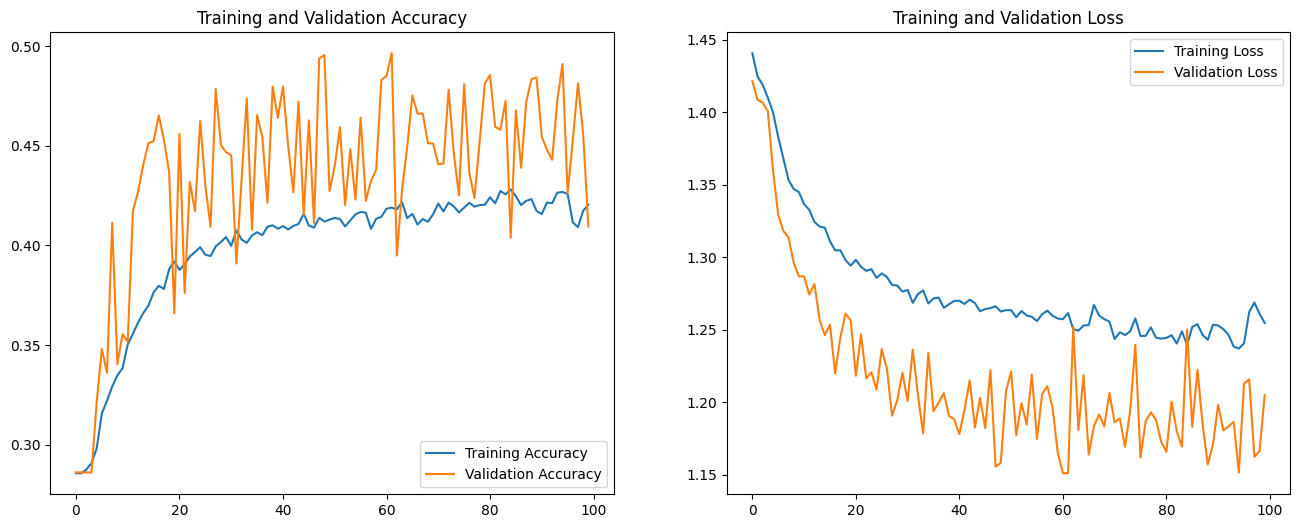

In [11]:
res_yuv_pre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 44s 96ms/step - loss: 1.4412 - accuracy: 0.2875 - val_loss: 1.4096 - val_accuracy: 0.3105
Epoch 2/100
360/360 [==============================] - 28s 77ms/step - loss: 1.4183 - accuracy: 0.2968 - val_loss: 1.4006 - val_accuracy: 0.3204
Epoch 3/100
360/360 [==============================] - 27s 76ms/step - loss: 1.4068 - accuracy: 0.3058 - val_loss: 1.3952 - val_accuracy: 0.2923
Epoch 4/100
360/360 [==============================] - 27s 75ms/step - loss: 1.4016 - accuracy: 0.3155 - val_loss: 1.3955 - val_accuracy: 0.3199
Epoch 5/100
360/360 [==============================] - 27s 75ms/step - loss: 1.3980 - accuracy: 0.3186 - val_loss: 1.3820 - val_accuracy: 0.3256
Epoch 6/100
360/360 [==============================] - 27s 76ms/step - loss: 1.3954 - accuracy: 0.3

Epoch 56/100
360/360 [==============================] - 27s 74ms/step - loss: 1.3343 - accuracy: 0.3721 - val_loss: 1.2920 - val_accuracy: 0.4033
Epoch 57/100
360/360 [==============================] - 27s 75ms/step - loss: 1.3341 - accuracy: 0.3770 - val_loss: 1.3032 - val_accuracy: 0.4281
Epoch 58/100
360/360 [==============================] - 27s 75ms/step - loss: 1.3362 - accuracy: 0.3723 - val_loss: 1.3042 - val_accuracy: 0.3922
Epoch 59/100
360/360 [==============================] - 27s 75ms/step - loss: 1.3378 - accuracy: 0.3689 - val_loss: 1.2952 - val_accuracy: 0.4224
Epoch 60/100
360/360 [==============================] - 27s 76ms/step - loss: 1.3350 - accuracy: 0.3733 - val_loss: 1.3089 - val_accuracy: 0.3934
Epoch 61/100
360/360 [==============================] - 27s 76ms/step - loss: 1.3343 - accuracy: 0.3712 - val_loss: 1.2903 - val_accuracy: 0.4337
Epoch 62/100
360/360 [==============================] - 27s 75ms/step - loss: 1.3352 - accuracy: 0.3727 - val_loss: 1.3017 -

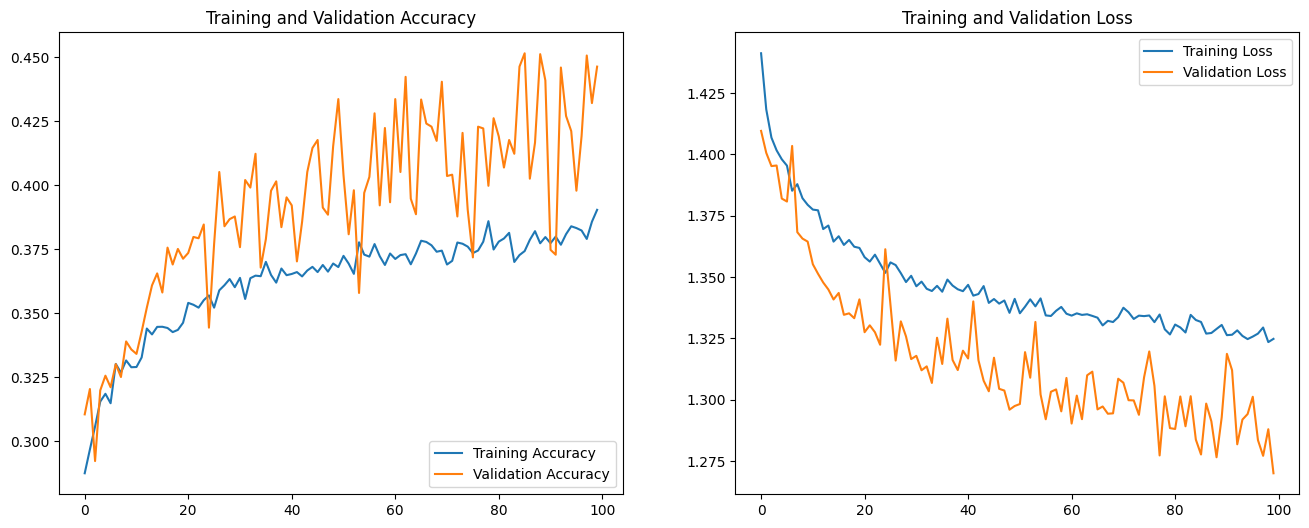

In [12]:
res_yuv_nonpre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 39s 82ms/step - loss: 1.4471 - accuracy: 0.2926 - val_loss: 1.4085 - val_accuracy: 0.2746
Epoch 2/100
360/360 [==============================] - 28s 76ms/step - loss: 1.4219 - accuracy: 0.3076 - val_loss: 1.4168 - val_accuracy: 0.2860
Epoch 3/100
360/360 [==============================] - 28s 78ms/step - loss: 1.4087 - accuracy: 0.3276 - val_loss: 1.3703 - val_accuracy: 0.3387
Epoch 4/100
360/360 [==============================] - 28s 76ms/step - loss: 1.3846 - accuracy: 0.3546 - val_loss: 1.3260 - val_accuracy: 0.4373
Epoch 5/100
360/360 [==============================] - 27s 76ms/step - loss: 1.3637 - accuracy: 0.3725 - val_loss: 1.3107 - val_accuracy: 0.4132
Epoch 6/100
360/360 [==============================] - 27s 75ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 27s 75ms/step - loss: 1.2605 - accuracy: 0.4404 - val_loss: 1.2045 - val_accuracy: 0.4576
Epoch 57/100
360/360 [==============================] - 27s 75ms/step - loss: 1.2570 - accuracy: 0.4400 - val_loss: 1.1838 - val_accuracy: 0.4700
Epoch 58/100
360/360 [==============================] - 27s 74ms/step - loss: 1.2614 - accuracy: 0.4368 - val_loss: 1.1836 - val_accuracy: 0.4814
Epoch 59/100
360/360 [==============================] - 27s 75ms/step - loss: 1.2558 - accuracy: 0.4391 - val_loss: 1.1809 - val_accuracy: 0.4739
Epoch 60/100
360/360 [==============================] - 27s 76ms/step - loss: 1.2508 - accuracy: 0.4455 - val_loss: 1.2217 - val_accuracy: 0.4528
Epoch 61/100
360/360 [==============================] - 27s 76ms/step - loss: 1.2515 - accuracy: 0.4491 - val_loss: 1.1847 - val_accuracy: 0.5010
Epoch 62/100
360/360 [==============================] - 27s 75ms/step - loss: 1.2546 - accuracy: 0.4452 - val_loss: 1.1803 -

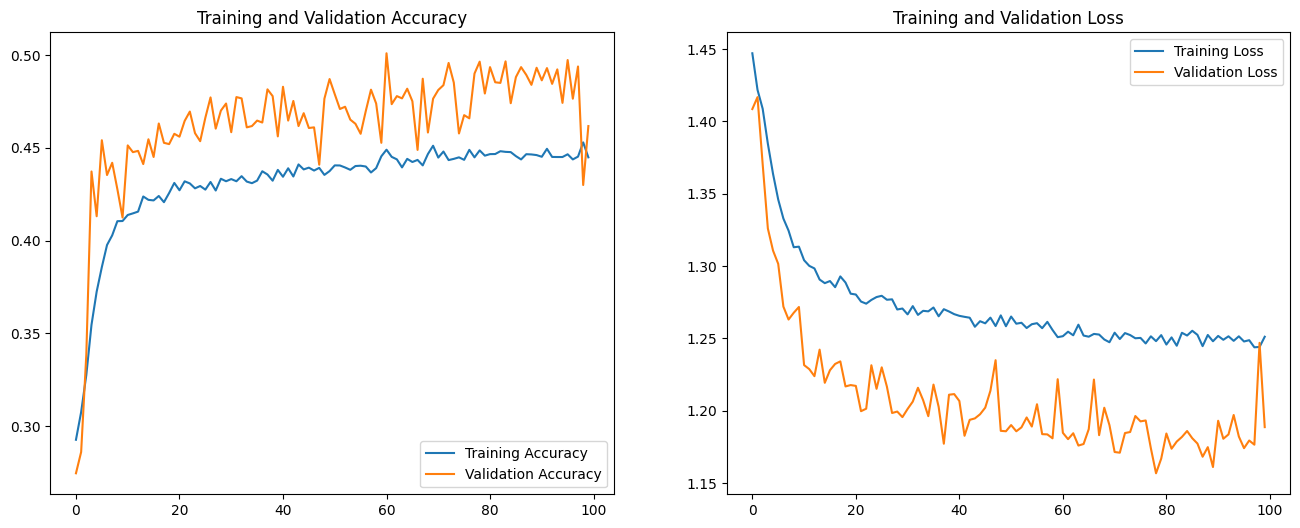

In [13]:
res_ydbdr_pre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=True)

In [14]:
res_ydbdr_nonpre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 39s 83ms/step - loss: 1.4234 - accuracy: 0.3099 - val_loss: 1.3960 - val_accuracy: 0.3310
Epoch 2/100
360/360 [==============================] - 28s 78ms/step - loss: 1.3768 - accuracy: 0.3432 - val_loss: 1.3318 - val_accuracy: 0.3722
Epoch 3/100
360/360 [==============================] - 27s 75ms/step - loss: 1.3453 - accuracy: 0.3590 - val_loss: 1.2920 - val_accuracy: 0.3810
Epoch 4/100
360/360 [==============================] - 27s 75ms/step - loss: 1.3219 - accuracy: 0.3805 - val_loss: 1.2786 - val_accuracy: 0.3859
Epoch 5/100
360/360 [==============================] - 28s 76ms/step - loss: 1.3126 - accuracy: 0.3862 - val_loss: 1.2617 - val_accuracy: 0.4352
Epoch 6/100
360/360 [==============================] - 28s 77ms/step - loss: 1.2945 - accuracy: 0.3

Epoch 56/100
360/360 [==============================] - 27s 75ms/step - loss: 1.2279 - accuracy: 0.4502 - val_loss: 1.1758 - val_accuracy: 0.4750
Epoch 57/100
360/360 [==============================] - 27s 75ms/step - loss: 1.2278 - accuracy: 0.4486 - val_loss: 1.1523 - val_accuracy: 0.4981
Epoch 58/100
360/360 [==============================] - 27s 75ms/step - loss: 1.2291 - accuracy: 0.4477 - val_loss: 1.1567 - val_accuracy: 0.4967
Epoch 59/100
360/360 [==============================] - 27s 75ms/step - loss: 1.2278 - accuracy: 0.4482 - val_loss: 1.1557 - val_accuracy: 0.4981
Epoch 60/100
360/360 [==============================] - 27s 75ms/step - loss: 1.2203 - accuracy: 0.4564 - val_loss: 1.1436 - val_accuracy: 0.4964
Epoch 61/100
360/360 [==============================] - 27s 76ms/step - loss: 1.2254 - accuracy: 0.4488 - val_loss: 1.1647 - val_accuracy: 0.4894
Epoch 62/100
360/360 [==============================] - 27s 75ms/step - loss: 1.2286 - accuracy: 0.4486 - val_loss: 1.1484 -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
# !mkdir resnet152_nontrainable
# pd.DataFrame(res_rgb).to_csv("resnet152_nontrainable/res_rgb.csv", index=False)
# pd.DataFrame(res_lab_pre).to_csv("resnet152_nontrainable/res_lab_pre.csv", index=False)
# pd.DataFrame(res_lab_nonpre).to_csv("resnet152_nontrainable/res_lab_nonpre.csv", index=False)
# pd.DataFrame(res_xyz_pre).to_csv("resnet152_nontrainable/res_xyz_pre.csv", index=False)
# pd.DataFrame(res_xyz_nonpre).to_csv("resnet152_nontrainable/res_xyz_nonpre.csv", index=False)
# pd.DataFrame(res_hsv_pre).to_csv("resnet152_nontrainable/res_hsv_pre.csv", index=False)
# pd.DataFrame(res_hsv_nonpre).to_csv("resnet152_nontrainable/res_hsv_nonpre.csv", index=False)
# pd.DataFrame(res_yuv_pre).to_csv("resnet152_nontrainable/res_yuv_pre.csv", index=False)
# pd.DataFrame(res_yuv_nonpre).to_csv("resnet152_nontrainable/res_yuv_nonpre.csv", index=False)
# pd.DataFrame(res_ydbdr_pre).to_csv("resnet152_nontrainable/res_ydbdr_pre.csv", index=False)
# pd.DataFrame(res_ydbdr_nonpre).to_csv("resnet152_nontrainable/res_ydbdr_nonpre.csv", index=False)